In [8]:
import numpy as np
import tensorflow as tf
from matplotlib import pylab as plt

In [4]:
data = np.load("burgers_data.npy")

In [7]:
Nsol,Nt,Nx = data.shape

In [10]:
data[5,0:2,:]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

This is the way of making the atomic stencil samples. This is the right idea, but let's pack it into the Conv1D framework to make it faster and easier to use.

In [34]:
Nsamp = Nsol*(Nt-1)*(Nx-2)
u_in = np.empty((Nsamp,3),dtype=np.float32)
u_out = np.empty((Nsamp,1),dtype=np.float32)
idx = 0
for i in range(Nsol):
    for j in range(Nt-1):
        for k in range(1,Nx-1):
            u_in[idx,:] = data[i,j,k-1:k+2]
            u_out[idx] = data[i,j+1,k]
            idx+=1

In [176]:
np.savez("burgers_prepped",u_in=u_in,u_out=u_out)

In [38]:
model = torch.nn.Sequential(
    torch.nn.Linear(3,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,20),
    torch.nn.ReLU(),
    torch.nn.Linear(20,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1),
)
loss = torch.nn.MSELoss(reduction='sum')

So, let's remake the dataset that ties together frames

In [35]:
u_out

array([[0.99      ],
       [1.08      ],
       [1.17      ],
       ...,
       [0.9416199 ],
       [0.97082037],
       [0.99160796]], dtype=float32)

In [94]:
Nsamp = Nsol*(Nt-1)
u_in = np.empty((Nsamp,Nx),dtype=np.float32)
u_out = np.empty((Nsamp,Nx-2),dtype=np.float32)
idx = 0
for i in range(Nsol):
    for j in range(Nt-1):
        u_in[idx,:]=data[i,j,:]
        u_out[idx,:] = data[i,j+1,1:-1]
        idx+=1

In [37]:
import torch

In [69]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(1,9,3),
    torch.nn.ReLU(),
    torch.nn.Conv1d(9,9,1),
    torch.nn.ReLU(),
    torch.nn.Conv1d(9,5,1),
    torch.nn.ReLU(),
    torch.nn.Conv1d(5,1,1)
)

In [95]:
to_u_in = torch.tensor(u_in).reshape((u_in.shape[0],1,u_in.shape[1]))
to_u_out = torch.tensor(u_out).reshape((u_out.shape[0],1,u_out.shape[1]))

In [96]:
loss(model(to_u_in),to_u_out)

tensor(3056.7429, grad_fn=<MseLossBackward>)

In [153]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(10**5):
    y_pred = model(to_u_in)
    lo = loss(y_pred, to_u_out)
    if t % 1000 == 99:
        print(t, lo.item())
    optimizer.zero_grad()
    lo.backward()
    optimizer.step()

99 124.12626647949219
199 123.50090789794922
299 122.88147735595703
399 122.2647705078125
499 121.65169525146484
599 121.04373931884766
699 120.4390640258789
799 119.84127807617188
899 119.24665069580078
999 118.65069580078125
1099 118.06156921386719
1199 117.47925567626953
1299 116.896240234375
1399 116.32051086425781
1499 115.74784851074219
1599 115.17970275878906
1699 114.61712646484375
1799 114.05802154541016
1899 113.50274658203125
1999 112.95063781738281
2099 112.40247344970703
2199 111.85517883300781
2299 111.3126220703125
2399 110.77498626708984
2499 110.23990631103516
2599 109.70828247070312
2699 109.18020629882812
2799 108.65437316894531
2899 108.1312026977539
2999 107.61090087890625
3099 107.0936050415039
3199 106.57897186279297
3299 106.06678009033203
3399 105.5573501586914
3499 105.05217742919922
3599 104.54896545410156
3699 104.04840087890625
3799 103.55085754394531
3899 103.05692291259766
3999 102.56472778320312
4099 102.07499694824219
4199 101.587646484375
4299 101.1029

KeyboardInterrupt: 

In [152]:
def plot_model(i):
    with torch.no_grad():
        uN = model(to_u_in[i:i+1,:,:])
    plt.plot(uN.numpy().flatten())
    plt.plot(np.r_[[0],u_out[i,:],[0]])

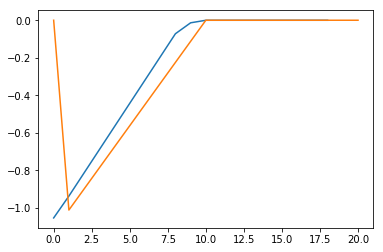

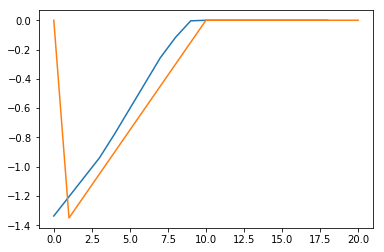

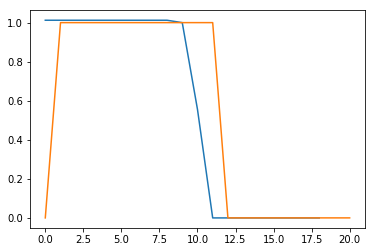

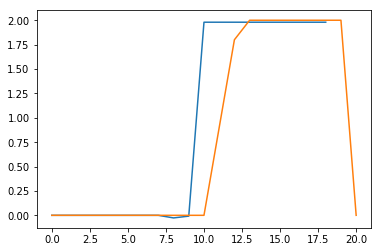

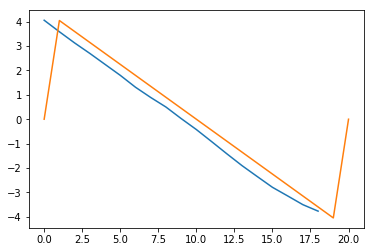

In [154]:
for i in range(5):
    s = np.random.randint(Nsamp)
    plt.figure()
    plot_model(s)

## Let's integrate it on itself now:

In [166]:
def do_a_path(samp):
    u0 = data[samp,0,:]
    u0 = u0.reshape((1,1,Nx))
    u0 = torch.tensor(u0,dtype=torch.float32)
    plt.figure()
    plt.plot(u0.numpy().flatten())
    with torch.no_grad():
        for i in range(10):
            uN = model(u0)
            u0[0,0,1:-1] = uN
            plt.plot(u0.numpy().flatten())
    plt.show()

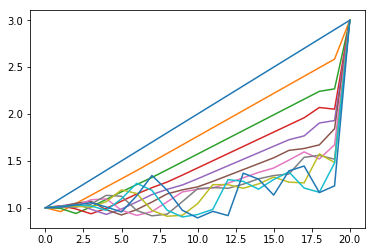

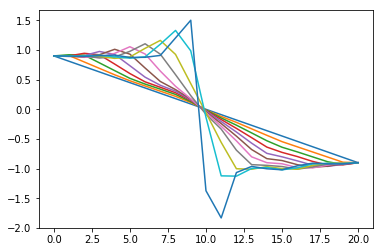

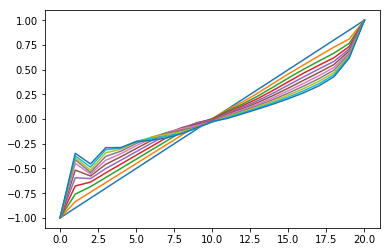

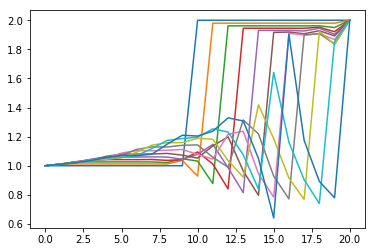

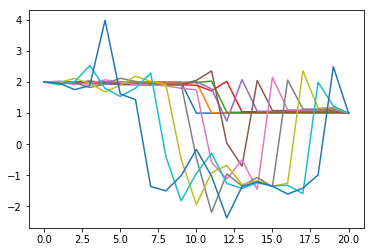

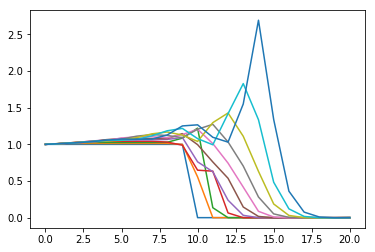

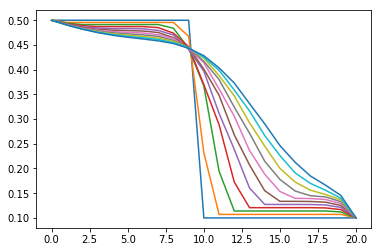

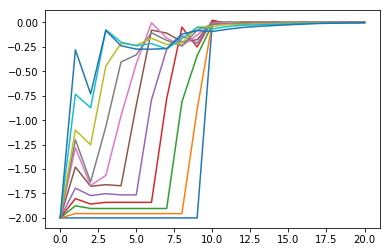

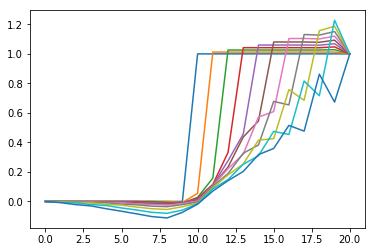

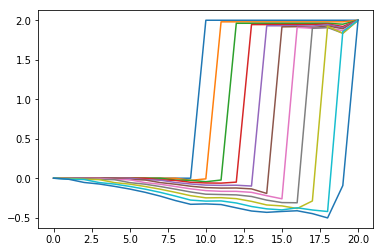

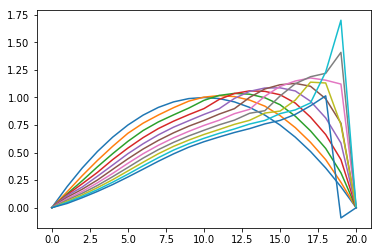

In [168]:
for i in range(Nsol):
    do_a_path(i)